# Snow Drought Classification
We begin our classification and definition of snow droughts first by using percentiles of SWE_max by year and then move to more complex methods.

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.gridspec as gridspec # custom layouts
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from statsmodels.distributions.empirical_distribution import ECDF

import matplotlib.ticker as mticker
import pandas as pd
from glob import glob
import statsmodels as sm
from scipy.stats import norm, gamma

# packages for netcdfs
import xarray as xr
import dask
import bottleneck
import datetime as dt

# packages for shape files and masking netcdfs
from shapely import wkb, wkt
from shapely.geometry import Point, shape, Polygon, MultiPolygon
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from rasterio import features
import fiona
import geopandas
import regionmask # for selecting regions from xarray

In [2]:
%%time
# open dataset and regrid
ds = xr.open_mfdataset("/Users/julianschmitt/Downloads/NOAA/livneh_swe/*.nc")

# old limits with 0.5 degree
lat_new = np.arange(25, 53, 0.5) 
lon_new = np.arange(235.5, 293, 0.5)
ds_low = ds.reindex(lat = lat_new, lon = lon_new, method='nearest') # takes a long time to run! 
ds_low.to_netcdf("/Users/julianschmitt/Downloads/NOAA/climatology/reindexed_full.nc")

/Users/julianschmitt/opt/anaconda3/envs/py38/lib/python3.8/site-packages/xarray/core/indexing.py:1385: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


CPU times: user 5min 57s, sys: 52.4 s, total: 6min 50s
Wall time: 5min 16s


In [3]:
# take max SWE over "Annual/Start of period" starting in October - get max SWE
ds_new = xr.open_dataset("/Users/julianschmitt/Downloads/NOAA/climatology/swe_reindexed.nc") # load to mem
ds_annual = ds_new.resample(time='AS-OCT').max('time') 
ds_annual

<xarray.Dataset>
Dimensions:  (lat: 56, lon: 115, time: 98)
Coordinates:
  * time     (time) datetime64[ns] 1914-10-01 1915-10-01 ... 2011-10-01
  * lat      (lat) float64 25.0 25.5 26.0 26.5 27.0 ... 50.5 51.0 51.5 52.0 52.5
  * lon      (lon) float64 235.5 236.0 236.5 237.0 ... 291.0 291.5 292.0 292.5
Data variables:
    swe      (time, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [4]:
# Load water regions into shape object
rootdir = "/Users/julianschmitt/Downloads/NOAA/basin_shp_files/"
poly = []
for ind in range(1, 19):
    fpath = os.path.join(rootdir, f"R{ind}/WBDHU2.shp")
    try: # add polygons to array - buffer with zero to retain size but fill gaps
        poly.append(Polygon(fiona.open(fpath, 'r')[0]['geometry']['coordinates'][0]).buffer(0))
    except ValueError:
        poly.append(Polygon(fiona.open(fpath,'r')[0]['geometry']['coordinates'][0][0]).buffer(0))
        
MP = MultiPolygon(poly) # mutlipolygon object contains all regions

In [6]:
# extract names and region labels for mask
names, huc2_region = [], []
for ind in range(1, 19):
    fpath = os.path.join(rootdir, f"R{ind}/WBDHU2.shp")
    names.append(fiona.open(fpath, 'r')[0]['properties']['Name'])
    huc2_region.append(fiona.open(fpath, 'r')[0]['properties']['HUC2'])
    
    
# convert shapes to mask
RM = regionmask.Regions(MP, names = names, abbrevs=huc2_region)

# Add mask to dataset
lat_new = np.arange(25, 53, 0.5) 
lon_new = np.arange(235.5, 293, 0.5)
mask = RM.mask(lon_new, lat_new) # create mask over dataset lat-lon

ds_annual['mask'] = mask # add mask to dataset

ds_regions = ds_annual.groupby('mask').mean() # take average snowfall over region
ds2 = ds_regions.assign_coords(regions=("mask", RM.names))
ds_regions


<xarray.Dataset>
Dimensions:  (mask: 18, time: 98)
Coordinates:
  * mask     (mask) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 13.0 14.0 15.0 16.0 17.0
  * time     (time) datetime64[ns] 1914-10-01 1915-10-01 ... 2011-10-01
Data variables:
    swe      (mask, time) float32 224.5 237.5 287.0 236.3 ... 93.39 158.9 8.713

## Snowfall Distributions for Sample Region 
We look at peak SWE values by year and create a empirical distribution function based off those values

In [8]:
# get sample region and data
print(RM.names[-2])
sample = ds2.swe[-2][1:-2]

Pacific Northwest Region


In [9]:
ecdf = ECDF(sample)

Text(0, 0.5, 'ECDF')

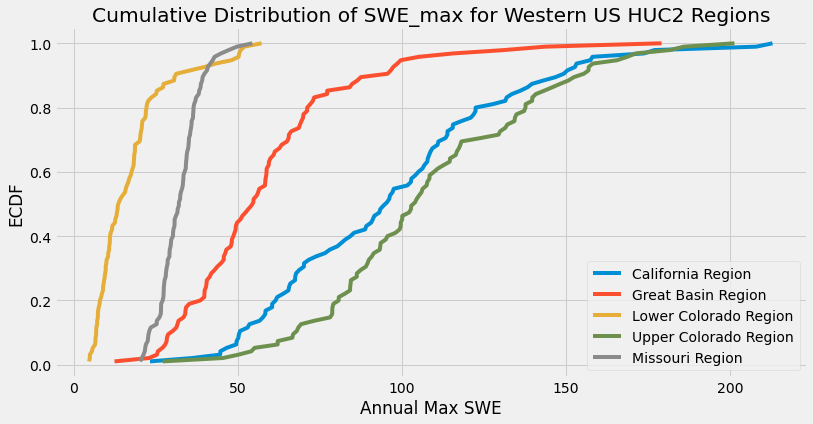

In [10]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,6))
for i in [1,3,4,5,9]:
    sample = ds2.swe[-i][1:-2]
    ecdf = ECDF(sample)
    name = RM.names[-i]
    plt.plot(ecdf.x, ecdf.y, label=name)
plt.legend()
plt.title("Cumulative Distribution of SWE_max for Western US HUC2 Regions")
plt.xlabel("Annual Max SWE")
plt.ylabel("ECDF")
#plt.savefig("/Users/julianschmitt/Documents/NOAA/plots/drought/ECDF_HUC2_minus_PNW.png", dpi=200)

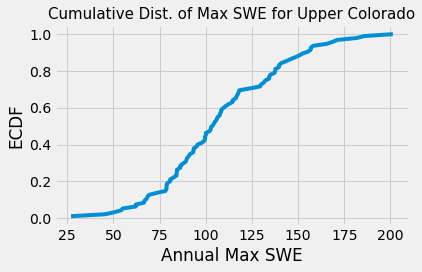

In [21]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6,4))

sample = ds2.swe[-5][1:-2]
ecdf = ECDF(sample)
name = RM.names[-5]
plt.plot(ecdf.x, ecdf.y, label=name)
#plt.legend()
plt.title("Cumulative Dist. of Max SWE for Upper Colorado", fontsize=15)
plt.xlabel("Annual Max SWE")
plt.ylabel("ECDF")
plt.tight_layout()
plt.savefig("/Users/julianschmitt/Documents/NOAA/plots/UC_ecdf.png", dpi=200)

In [83]:
ecdf.x
def percentile(ecdf, swe_avg):
    """Takes ECDF object and avg swe and returns percentile"""
    rank = [n for n,i in enumerate(ecdf.x[1:]) if i>swe_avg][0]
    p = rank/len(ecdf.x)
    return p
percentile(ecdf, 30)

0.3854166666666667

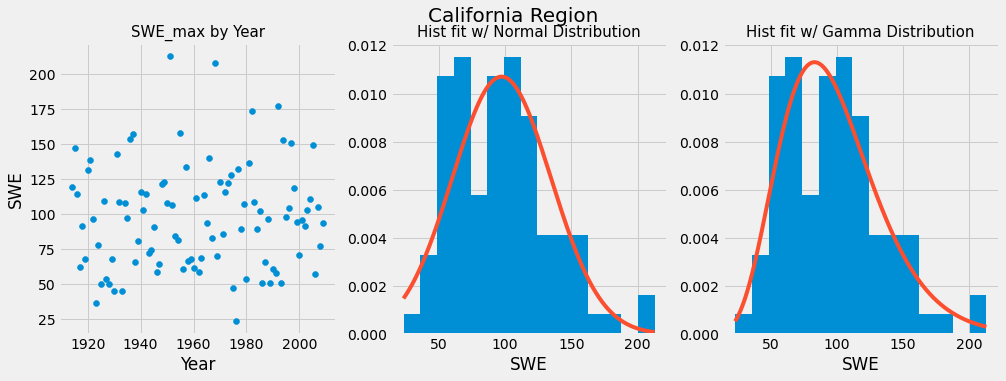

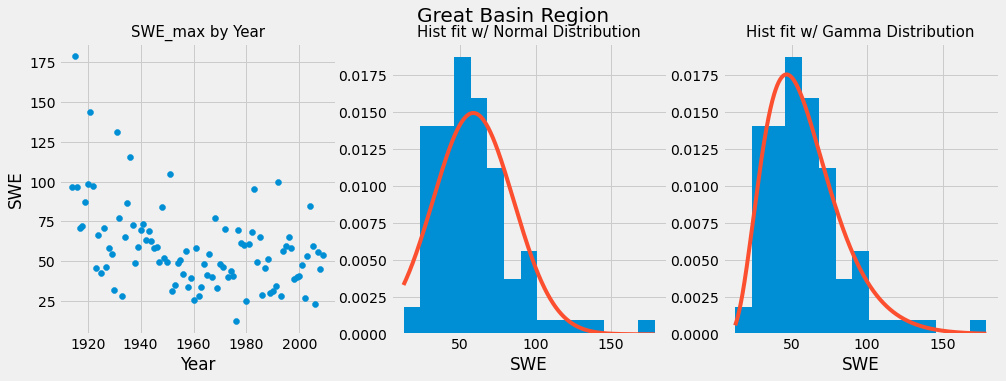

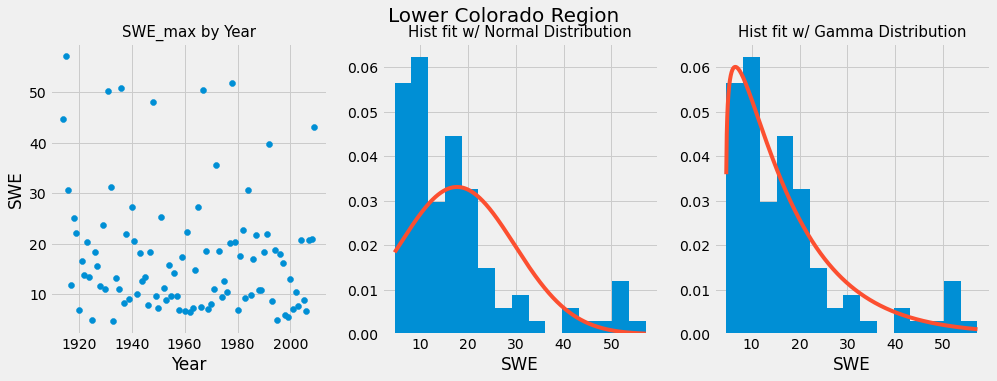

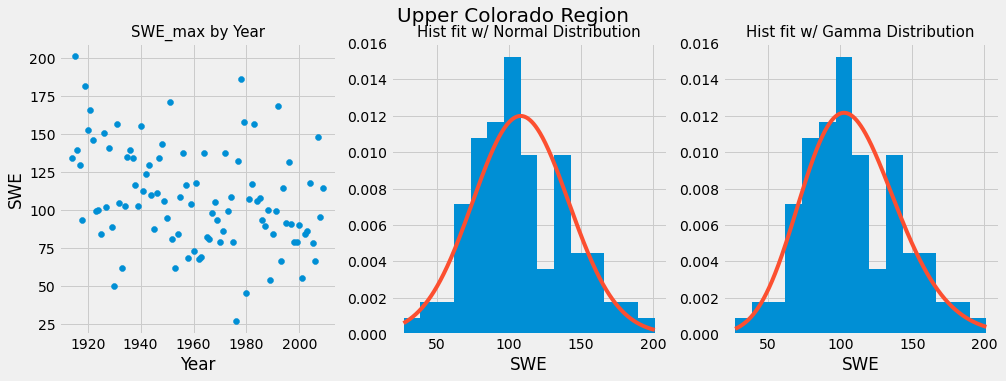

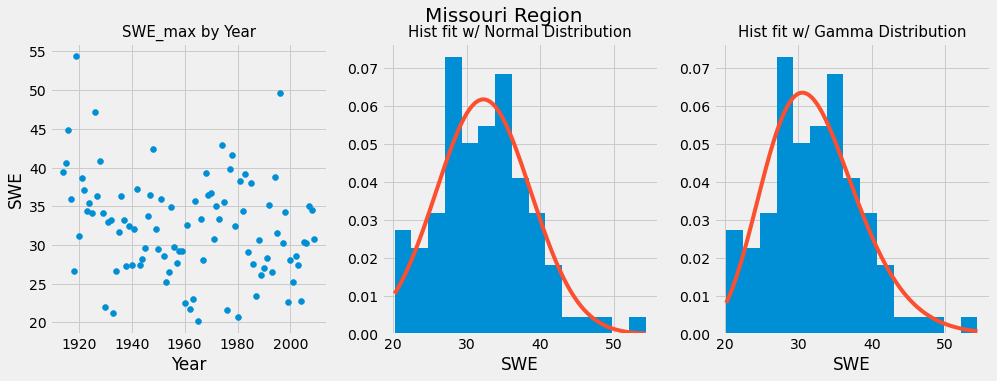

In [166]:
for i in [1,3,4,5,9]:
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    data = ds2.swe[-i][:-2]
    ax[0].scatter(range(1914,2010), data);
    ax[1].hist(data, bins=15, density=True)
    ax[2].hist(data, bins=15, density=True)
    x = np.linspace(min(data), max(data), 1000)
    # plot normal distribution 
    ax[1].plot(x, norm.pdf(x, np.mean(data), np.std(data)))

    # fit and plot gamma distribution
    fit_alpha, fit_loc, fit_beta=gamma.fit(data)
    ax[2].plot(x, gamma.pdf(x, fit_alpha, fit_loc, fit_beta))

    plt.suptitle(names[-i], fontsize=20)

    ax[0].set_title("SWE_max by Year", fontsize=15)
    ax[0].set_ylabel("SWE")
    ax[0].set_xlabel("Year")
    ax[1].set_title("Hist fit w/ Normal Distribution", fontsize=15)
    ax[1].set_xlabel("SWE")
    ax[2].set_xlabel("SWE")
    ax[2].set_title("Hist fit w/ Gamma Distribution", fontsize=15)
    fig.savefig(f"../../plots/drought/{names[-i]}_distr_comparison.png")

In [254]:
def drought_index(ds, region, swe_amount):
    """Year starts in the fall: eg 2014 = winter 2014-2015"""
    print(f"Drought Index for: {names[region]}")
    #index = year-1914 # get array index for drought year
    data = ds.swe[region] # snow fall data
    ecdf = ECDF(data)
    try:
        index = [x for x, n in enumerate(ecdf.x) if n > swe_amount][0]
    except IndexError:
        print(f"{np.array(ds.regions[region])}: Most SNOW EVER!!")
        return norm.ppf(ecdf.y)[-2] # -1 is default infinity

    zscore = norm.ppf(ecdf.y)[index]  # inverse normal 
    return zscore
drought_index(ds2, -2, 500)

Drought Index for: Pacific Northwest Region
Pacific Northwest Region: Most SNOW EVER!!


2.318757970977832

In [242]:
# Select Snowy HUC2 regions in the US West
snow = ds2[dict(mask=[-1,-2, -3,-5])]
snow

<xarray.Dataset>
Dimensions:  (mask: 4, time: 98)
Coordinates:
  * mask     (mask) float64 17.0 16.0 15.0 13.0
  * time     (time) datetime64[ns] 1914-10-01 1915-10-01 ... 2011-10-01
    regions  (mask) <U26 'California Region' ... 'Upper Colorado Region'
Data variables:
    swe      (mask, time) float32 118.9 146.8 113.8 61.98 ... 114.5 143.1 27.2

In [305]:
def drought_class(zscore):
    """Simple drought classification"""
    if zscore <=-2:
        return "D4"
    if -2<zscore<-1.6:
        return "D3"
    if -1.6 < zscore < -1.3:
        return "D2"
    if -1.3 < zscore < -0.8:
        return "D1"
    if -0.8 < zscore < -0.5:
        return "D0"
    if -0.5 < zscore < 0.5:
        return "NN"
    if 0.5 < zscore < 0.8: 
        return "W0"
    if 0.8 < zscore < 1.3:
        return "W1"
    if 1.3 < zscore < 1.6:
        return "W2"
    if 1.6 < zscore < 2.0:
        return "W3"
    if zscore >=2:
        return "W4"
    
def drought_index(ds, region, year):
    """Year starts in the fall: eg 2014 = winter 2014-2015"""
    
    # index data - get range of data
    index = np.array(ds.mask)[list(np.array(ds.regions)).index(region)]
    data = np.array(ds.loc[dict(mask=index)].swe)
    # select swe value from mask and time given
    season_swe = np.array(ds.loc[dict(mask=index, time=slice(f"{year}-10-01", f"{year+1}-01-01"))].swe)[0]
    
    ecdf = ECDF(data)
    try:
        index = [x for x, n in enumerate(ecdf.x) if n > season_swe][0]
    except IndexError:
        print(f"{np.array(ds.regions[region])}: Most SNOW EVER!!")
        return norm.ppf(ecdf.y)[-2] # -1 is default infinity

    zscore = norm.ppf(ecdf.y)[index]  # inverse normal 
    
    return {region: zscore}
# snow.loc[dict(time=slice("2000-01-01", "2005-01-01"),mask=13)]
drought_index(ds2, "Pacific Northwest Region", 2010)

{'Pacific Northwest Region': 1.0675705238781412}

In [300]:
# Get deviation values 
all_regions = np.array(ds2.regions)
west_regions = np.array(ds2.regions)[[-1,-2, -3,-5]]
west_dict = {}
for region in west_regions:
    rdict = drought_index(ds2, region, 2008)
    west_dict.update(rdict)
west_dict

{'California Region': -0.36610635680056963,
 'Pacific Northwest Region': -0.5068716225579336,
 'Great Basin Region': -0.4495135654566907,
 'Upper Colorado Region': -0.2322722934826261}

In [508]:
year=2008
all_dict = {}
for region in all_regions:
    rdict = drought_index(ds2, region, year)
    all_dict.update(rdict)
all_dict


{'New England Region': 0.4495135654566905,
 'Mid Atlantic Region': 0.2586330669514177,
 'South Atlantic-Gulf Region': -0.7571172975708611,
 'Great Lakes Region': 1.1628312902007807,
 'Ohio Region': 1.6350392668017102,
 'Tennessee Region': -0.7571172975708611,
 'Upper Mississippi Region': 0.18001236979270496,
 'Lower Mississippi Region': 0.8636956533670369,
 'Souris-Red-Rainy Region': 1.0675705238781412,
 'Missouri Region': 0.4213912770678051,
 'Arkansas-White-Red Region': 0.3388883015533141,
 'Texas-Gulf Region': -1.6350392668017106,
 'Rio Grande Region': -0.8271302058416301,
 'Upper Colorado Region': -0.2322722934826261,
 'Lower Colorado Region': 0.7234755745418949,
 'Great Basin Region': -0.4495135654566907,
 'Pacific Northwest Region': -0.5068716225579336,
 'California Region': -0.36610635680056963}

In [306]:
# Classify drought
drought_class(west_dict["California Region"])



'NN'

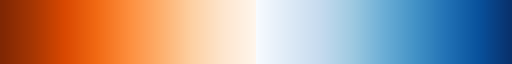

In [328]:
# make drought cmap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')
drought_cmp =[newcmp(i) for i in range(0,newcmp.N, 11)]
newcmp

<GeoAxesSubplot:>

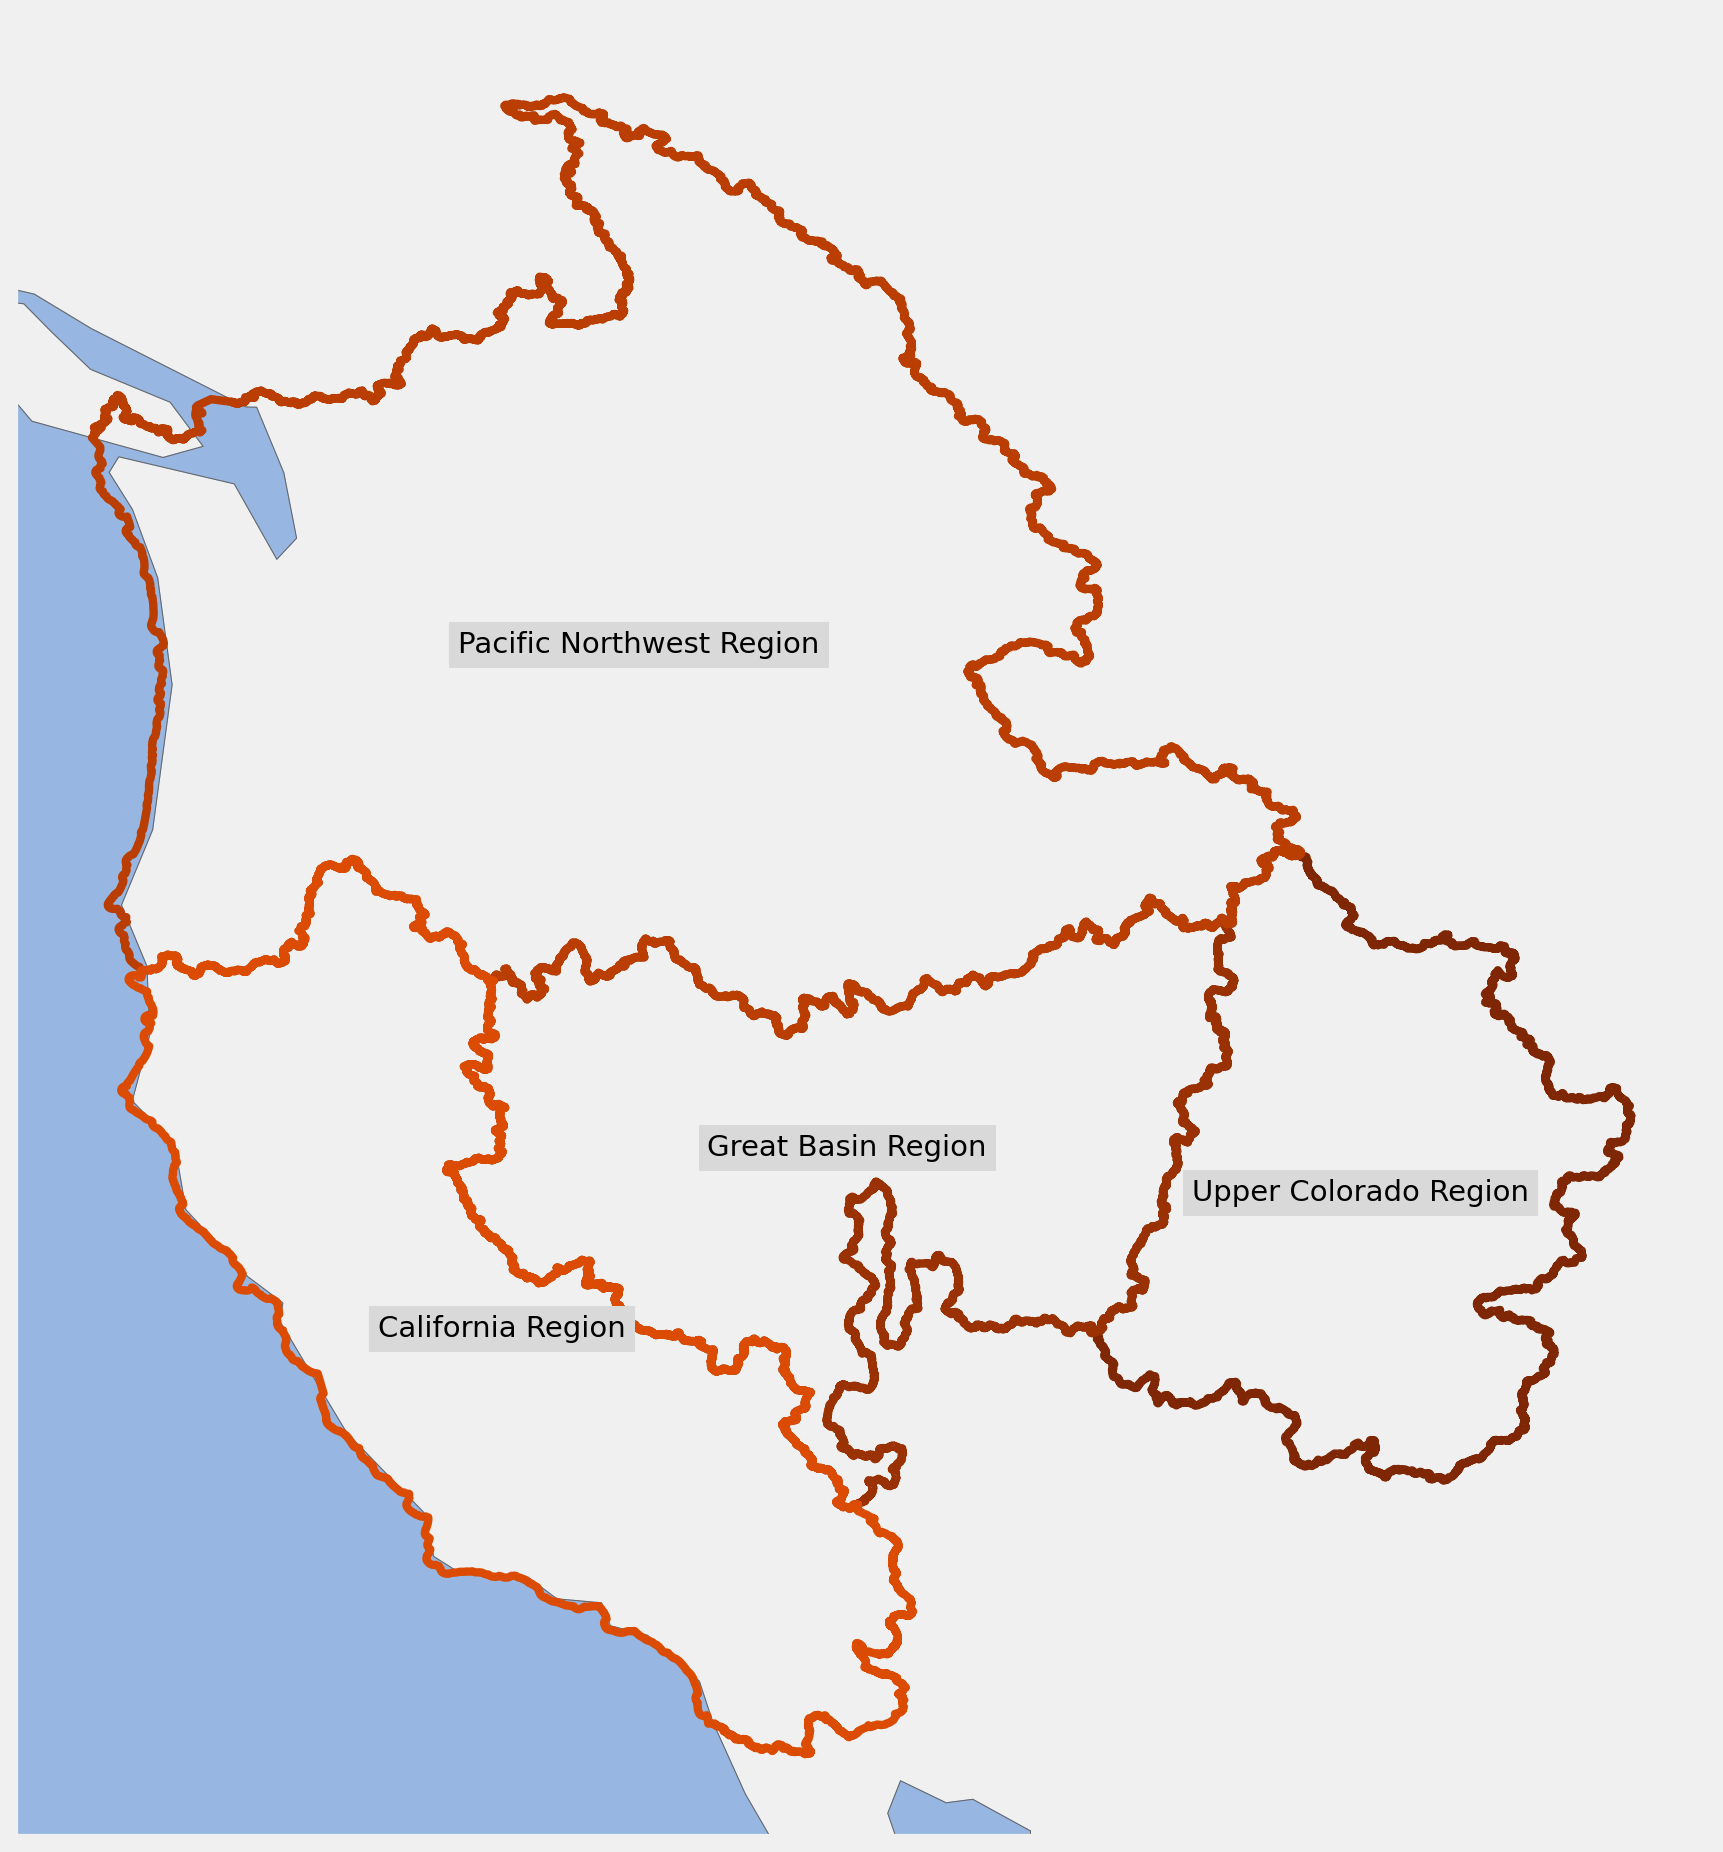

In [346]:

plt.figure(figsize=(20, 15), dpi=150)

regions = ["California Region", "Pacific Northwest Region", "Great Basin Region", "Upper Colorado Region"]
RM.plot(label="name", regions = regions, add_ocean=True, line_kws=dict(colors=drought_cmp))


In [267]:
index = np.array(snow.mask)[list(np.array(snow.regions)).index("California Region")]
index

17.0

In [278]:
year=2010
np.array(snow.loc[dict(mask=index, time=slice(f"{year}-10-01", f"{year+1}-01-01"))].swe)[0]

158.931

In [ ]:
# add swe data
# swe = ds_annual.isel(time=-2).swe.plot.contourf(ax=ax,
#                                                transform=ccrs.PlateCarree(),
#                                                vmax=500,
#                                                cmap=snow_cmap, zorder=3, alpha=0.5)
#ax.add_feature(mask, edgecolor="black")

In [520]:
# supporting variables
year=2009 # pick year to view

# get drought indices
all_dict = {}
for region in all_regions:
    rdict = drought_index(ds2, region, year)
    all_dict.update(rdict)
all_dict

# create reionmask, filling drought indices
RM2 = regionmask.Regions(MP, names = names, abbrevs=huc2_region, numbers = list(all_dict.values()))
lat_new = np.arange(25, 53, 0.05)
lon_new = np.arange(235.5, 293, 0.05)
drought = RM2.mask(lon_new, lat_new) # create mask over dataset lat-lon

# read HUC2 region files to add as plot layer
HUC2 = ShapelyFeature(Reader("/Users/julianschmitt/Downloads/huc2_regions.shp").geometries(),
                             crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.5)



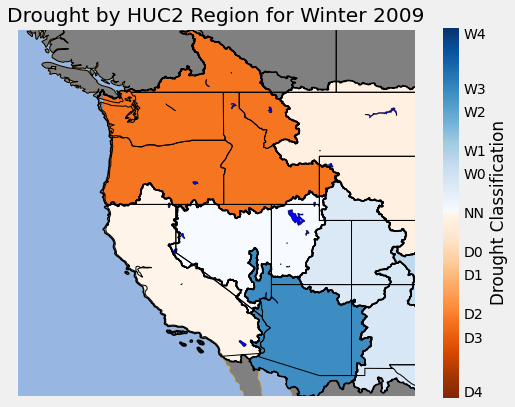

In [525]:
plt.figure(figsize=(8,8))

# get snow cmap
snow_cmap = matplotlib.cm.get_cmap('Blues_r')
#snow_cmap.set_bad(color='gray')

# get states
states = cfeature.NaturalEarthFeature(category='cultural',
                                     name='admin_1_states_provinces_shp',
                                     scale='50m',
                                     facecolor='none',
                                     edgecolor='black',
                                     linewidth=1)
# load projection
ax = plt.axes(projection=ccrs.PlateCarree())

# add land, lakes, oceans, and HUC2 regions
ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(HUC2)
# add states 
ax.add_feature(states)



# define new regionmask where values represent drought conditions
# uncomment when doing different year - save computation speed for now

dry = drought.plot(ax=ax, transform = ccrs.PlateCarree(), add_colorbar=False,
         cmap=newcmp, vmin=-2.4, vmax=2.4)

#cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(cmap=newcmp, ax=ax, cax=cax)

cbar_ticks = [-2.3, -1.6, -1.3, -0.8, -0.5, 0, 0.5, 0.8, 1.3, 1.6, 2.3]
yticklabels=['D4', 'D3', 'D2', 'D1', 'D0', 'NN', 'W0', 'W1', 'W2', 'W3', 'W4']
cbar = plt.colorbar(dry, 
                   orientation='vertical',
                   shrink=0.8,
                   ticks=cbar_ticks)
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label("Drought Classification",  labelpad=4)


# set extent to Western US
ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())

# set plot attributes and labels
ax.set_title(f"Drought by HUC2 Region for Winter {year}");
plt.savefig(f"/Users/julianschmitt/Documents/NOAA/plots/drought/huc2_drought_{year}.png", dpi=200)


# Combine SWE by HUC4 
We look more granularly at watershed regions for determining SWE

In [715]:
# combine HUC2 regions into 1 shape file 
import geopandas as gpd
geopoly = []
for ind in range(1, 19):
    fpath = os.path.join(rootdir, f"R{ind}/WBDHU2.shp")
    geopoly.append(gpd.read_file(fpath))
gdf = gpd.GeoDataFrame(pd.concat(geopoly))
gdf.to_file('/Users/julianschmitt/Downloads/huc2_regions.shp')

In [634]:
# load HUC4 regions into Multipolygon object
HUC4 = MultiPolygon([poly.buffer(0) for poly in gdf['geometry']])


In [639]:
# mask region
HUC4_names, HUC4_abbrev = gdf['Name'], gdf['HUC4']
RM4 = regionmask.Regions(HUC4, names = HUC4_names.values, abbrevs=HUC4_abbrev.values)
lat_new = np.arange(25, 53, 0.5) # must match range of SWE dataset - otherwise fills nans
lon_new = np.arange(235.5, 293, 0.5)
drought = RM4.mask(lon_new, lat_new) # create mask over dataset lat-lon

ds_HUC4 = ds_annual.copy()
ds_HUC4['mask'] = drought


In [2]:
ds2_HUC4 = ds_HUC4.groupby('mask').mean()
ds2_HUC4 = ds2_HUC4.assign_coords(regions=("mask", RM4.names[0:-1]))

In [696]:
def drought_index(ds, region, year):
    """Year starts in the fall: eg 2014 = winter 2014-2015"""
    regionname = str(np.array(region))
    # index data - get range of data
    index = np.array(ds.mask)[list(np.array(ds.regions)).index(region)]
    data = np.array(ds.loc[dict(mask=index)].swe)
    # select swe value from mask and time given
    season_swe = np.array(ds.loc[dict(mask=index, time=slice(f"{year}-10-01", f"{year+1}-01-01"))].swe)[0]
    
    ecdf = ECDF(data)
    swe_index = int(np.round(len(data)/2))
    try:
        swe_index = [x for x, n in enumerate(ecdf.x) if n > season_swe][0]
    except IndexError:
        print(f"{np.array(ds.regions[int(index)])}: Most SNOW EVER!!")
        return {regionname:norm.ppf(ecdf.y)[-2]} # -1 is default infinity

    zscore = norm.ppf(ecdf.y)[swe_index]  # inverse normal 
    return {regionname: zscore}
#drought_index(ds2_HUC4, all_regions[0], 2010)

In [707]:
year=2009 # pick year to view

# get drought indices
all_regions = ds2_HUC4.regions
all_dict = {}
for region in all_regions:
    rdict = drought_index(ds2_HUC4, region, year)
    all_dict.update(rdict)
all_dict

# create reionmask, filling drought indices
RM4 = regionmask.Regions(HUC4, names = list(all_dict.keys()), numbers = list(all_dict.values()))
lat_new = np.arange(25, 53, 0.05) # lat range for mask
lon_new = np.arange(235.5, 293, 0.05)
drought = RM4.mask(lon_new, lat_new) # create mask over dataset lat-lon

# read HUC2 region files to add as plot layer
HUC4 = ShapelyFeature(Reader("/Users/julianschmitt/Downloads/huc4_regions.shp").geometries(),
                             crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.5)

Southern Florida: Most SNOW EVER!!
Lake Ontario: Most SNOW EVER!!
Northwestern Lake Superior: Most SNOW EVER!!
Lake Huron: Most SNOW EVER!!
Lake Superior: Most SNOW EVER!!
Northeastern Lake Superior: Most SNOW EVER!!
Eastern Georgia Bay: Most SNOW EVER!!
Wanipitai River-French River: Most SNOW EVER!!
Lower Saint Lawrence River: Most SNOW EVER!!
Long Lake-Kenogami River: Most SNOW EVER!!
Mojikit Lake-Ogoki River: Most SNOW EVER!!
Eastern Lake Huron: Most SNOW EVER!!
Lake Erie: Most SNOW EVER!!
Des Moines: Most SNOW EVER!!
Saskatchewan River: Most SNOW EVER!!
Missouri-Nishnabotna: Most SNOW EVER!!
Rio Conchos: Most SNOW EVER!!
Rio Salado: Most SNOW EVER!!
Rio San Juan: Most SNOW EVER!!


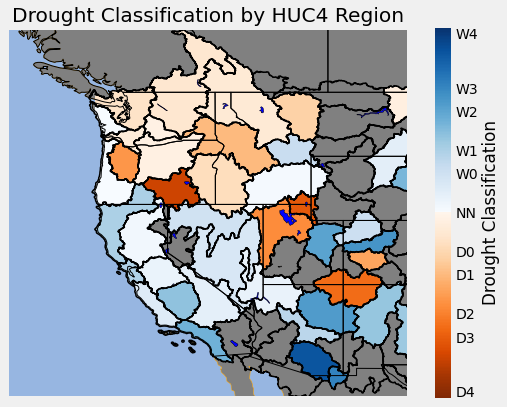

In [714]:
plt.figure(figsize=(8,8))

# get snow cmap
snow_cmap = matplotlib.cm.get_cmap('Blues_r')
#snow_cmap.set_bad(color='gray')

# get states

# load projection
ax = plt.axes(projection=ccrs.PlateCarree())


ax.add_feature(HUC4)

ax.add_feature(cfeature.LAND, edgecolor="orange", facecolor="grey", zorder=0)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor="blue")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(states)


ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())

dry = drought.plot(ax=ax, transform = ccrs.PlateCarree(), add_colorbar=False,
         cmap=newcmp, vmin=-2.4, vmax=2.4)

cbar_ticks = [-2.3, -1.6, -1.3, -0.8, -0.5, 0, 0.5, 0.8, 1.3, 1.6, 2.3]
yticklabels=['D4', 'D3', 'D2', 'D1', 'D0', 'NN', 'W0', 'W1', 'W2', 'W3', 'W4']
cbar = plt.colorbar(dry, 
                   orientation='vertical',
                   shrink=0.8,
                   ticks=cbar_ticks)
cbar.ax.set_yticklabels(yticklabels)
cbar.set_label("Drought Classification",  labelpad=4)


# set extent to Western US
ax.set_extent((-130, -105, 30, 53), crs=ccrs.PlateCarree())

ax.set_title("Drought Classification by HUC4 Region");
plt.savefig(f"/Users/julianschmitt/Documents/NOAA/plots/drought/huc4_drought_{year}.png", dpi=200)

In [465]:
#len(all_dict.values())
RM2 = regionmask.Regions(MP, names = names, abbrevs=huc2_region, numbers = list(all_dict.values()))

lat_new = np.arange(25, 53, 0.5) 
lon_new = np.arange(235.5, 293, 0.5)
drought = RM2.mask(lon_new, lat_new) # create mask over dataset lat-lon
drought[15,15]

<xarray.DataArray 'region' ()>
array(-0.36610636)
Coordinates:
    lat      float64 32.5
    lon      float64 243.0

In [1]:
regionmask.from_geopandas(RM)#.to_file("/Users/julianschmitt/Downloads/HUC2_regions.shp")

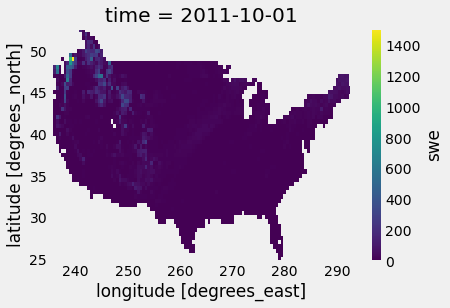

In [378]:
# Plot last time using xarray plotting features - less control than cartopy
ds_annual.isel(time=-1).swe.plot()